# **Lyft Bay Wheels Ridership Recommendations**
### Sophia Skowronski | Project 1
### Summer 2020 | MIDS w205 | Fundamentals of Data Engineering 

In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## **Defining "commuters" within our ridership data**

Within the data collected over three years by Lyft Bay Wheels (formerly Ford GoBike), it is the intent of this report to suggest a definition of a "commuter trip" as well as provide recommendations for deals to generate additional business revenue. This exploration and analysis is the first step for much deeper dive.

### Data Cleaning

It is essential that we look for any problematic data first before moving ahead with any exploration or analysis. 

`bikeshare_trips`: timeseries data that contains all of the individual trip details
- 983,648 rows
- 1 duplicate trip: the same bike and trip details (start/end stations and date) was recorded twice under separate `trip_id`s. Since it is just one data point, it has negligible influence on the entire dataset and can be ignored.
- No missing data

`bikeshare_status`: timeseries dataset that provides number of available bikes and dock ports at any station
- No missing data
- No duplicates

`bikeshare_stations`: summary of each station (name and location)

Beyond the basic sanity checks for each dataset, I found a number of inconsistencies:

### Installation timestamp inconsistency

Stations 30, 33, and 73 all have a significant amount of trips that started before the station was supposedly installed. This could be due to a typo with the recorded `station_id`, or the installation date can also include later updates to existing stations. The lack of description in the schema for the `installation_date` variable makes it unclear if it's worth removing from analysis. If any of these stations show up in a future query, I will investigate the data further.

In [353]:
%%bigquery

SELECT
COUNT(*) AS trip_count,
is_installation_error,
start_station_id,
installation_date
FROM (SELECT *, CASE WHEN EXTRACT(DATE FROM start_date) < installation_date THEN TRUE ELSE FALSE END AS is_installation_error,
FROM `bigquery-public-data.san_francisco.bikeshare_trips` AS t
JOIN (SELECT station_id, installation_date FROM`bigquery-public-data.san_francisco.bikeshare_stations`) AS t2 ON t2.station_id = t.start_station_id)
WHERE start_station_id IN (30,33,73)
GROUP BY start_station_id, installation_date, is_installation_error
ORDER BY start_station_id DESC, is_installation_error

,trip_count,is_installation_error,start_station_id,installation_date
0,1848,False,73,2016-05-19
1,21193,True,73,2016-05-19
2,312,False,33,2015-09-28
3,1202,True,33,2015-09-28
4,66,False,30,2015-09-28
5,1738,True,30,2015-09-28


### Dock count inconsistency

This problem with station 73 appears again when I calculate if there are any inconsistencies between the dockcount from the summary `stations` dataset with a record of the dockcount in the timeseries `status` dataset.

I merged both with the timeseries `trips` dataset to catch any differences with the live dock count calculations for the start and end stations. Since the `dockcount` variable is from the stationary `stations` dataset, it may just represent the most recent recording of dock counts. It is likely that the number of dock counts for some or all stations has changed since the company started the program.

From any future analysis, the variable `dockcount` should not be included.

In [354]:
%%bigquery

SELECT
start_station_id,
SUM(CASE WHEN start_bikes_available+start_docks_available != start_dockcount THEN 1 ELSE 0 END) as start_dock_error,

FROM (SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` AS t
JOIN (SELECT station_id as station_id1, bikes_available as start_bikes_available, docks_available as start_docks_available, TIMESTAMP_TRUNC(time, MINUTE) as time1, FROM `bigquery-public-data.san_francisco.bikeshare_status`) AS t1 ON (t1.station_id1=t.start_station_id AND t1.time1 =t.start_date)
JOIN (SELECT station_id as station_id2, bikes_available as end_bikes_available, docks_available as end_docks_available, TIMESTAMP_TRUNC(time, MINUTE) as time2, FROM `bigquery-public-data.san_francisco.bikeshare_status`) AS t2 ON (t2.station_id2=t.end_station_id AND t2.time2 =t.end_date)) AS k
JOIN (SELECT station_id as station_id3, dockcount as start_dockcount FROM `bigquery-public-data.san_francisco.bikeshare_stations`) AS k1 ON k1.station_id3=k.start_station_id
JOIN (SELECT station_id as station_id4, dockcount as end_dockcount FROM `bigquery-public-data.san_francisco.bikeshare_stations`) AS k2 ON k2.station_id4=k.end_station_id

GROUP BY start_station_id
ORDER BY start_dock_error DESC
LIMIT 5

,start_station_id,start_dock_error
0,73,20043
1,77,8226
2,61,8024
3,74,7456
4,69,5873


In [355]:
%%bigquery

SELECT
end_station_id,
SUM(CASE WHEN end_bikes_available+end_docks_available != end_dockcount THEN 1 ELSE 0 END) as end_dock_error,

FROM (SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` AS t
JOIN (SELECT station_id as station_id1, bikes_available as start_bikes_available, docks_available as start_docks_available, TIMESTAMP_TRUNC(time, MINUTE) as time1, FROM `bigquery-public-data.san_francisco.bikeshare_status`) AS t1 ON (t1.station_id1=t.start_station_id AND t1.time1 =t.start_date)
JOIN (SELECT station_id as station_id2, bikes_available as end_bikes_available, docks_available as end_docks_available, TIMESTAMP_TRUNC(time, MINUTE) as time2, FROM `bigquery-public-data.san_francisco.bikeshare_status`) AS t2 ON (t2.station_id2=t.end_station_id AND t2.time2 =t.end_date)) AS k
JOIN (SELECT station_id as station_id3, dockcount as start_dockcount FROM `bigquery-public-data.san_francisco.bikeshare_stations`) AS k1 ON k1.station_id3=k.start_station_id
JOIN (SELECT station_id as station_id4, dockcount as end_dockcount FROM `bigquery-public-data.san_francisco.bikeshare_stations`) AS k2 ON k2.station_id4=k.end_station_id

GROUP BY end_station_id
ORDER BY end_dock_error DESC
LIMIT 5

,end_station_id,end_dock_error
0,73,11243
1,61,8975
2,77,8678
3,74,8175
4,70,7523


### Definition #1: One-way rides

One-way trips can be defined as trips where the rider starts and ends at different locations. The other use case is for a round trip, where the individual takes the bike for errands, recreation, etc. and expects to be able to return the bike to the same place as where they picked it up. Because of our pricing structure, our riders are not incentized to park the bike for longer periods of time, and as a result, parking a bike at a workplace would lead to enormous costs. Commuters who are on their way to work would most likely be characterized by one-way trips.

When you filter the data by this condition, you see that one-way trips consist of the large majority of usage, with round trips only accounting for 3.26% of the total.

In [263]:
%%bigquery

SELECT 
CASE WHEN start_station_id = end_station_id THEN "round trip" ELSE "one-way" END AS trip_type, 
COUNT(*) AS trip_count,
ROUND(COUNT(*) / SUM(COUNT(*)) OVER (),4)*100 AS percent_of_total,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY trip_type
ORDER BY percent_of_total DESC

,trip_type,trip_count,percent_of_total
0,one-way,951601,96.74
1,round trip,32047,3.26


### Definition #2: Subscribers

It is also important to look at the one-way trip data and see how the ridership numbers change based on the individual's subscription. When you  compare the percentages of Subscribers and Customers, most one-way trips are taken by those who have signed up as a Subscriber, with over 87% of the total. There may be an opportunity with the remaining $\sim$12% of Customer trips that I will address later on.

In [264]:
%%bigquery

SELECT 
subscriber_type,
COUNT(*) AS trip_count,
ROUND(COUNT(*) / SUM(COUNT(*)) OVER (),4)*100 AS percent_of_total,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_id != end_station_id # One-way trip filter
GROUP BY subscriber_type

,subscriber_type,trip_count,percent_of_total
0,Subscriber,836945,87.95
1,Customer,114656,12.05


###  Definition #3: Peak usage between 7-10AM (morning commute) and 4-7PM (afternoon commute)

We can validate our previous definitions further by counting the number of trips taken by hour for either type of subscription. In the histogram below, you can see that there is very different behavior between the two subscription types. 

For customers, there is a small bump in usage in the early to late afternoon (starting between 12-6PM), and for subscribers, there is both a morning (starting between 7-10AM) and late afternoon (starting between 4-7PM) sharp peak in trips. By binning by the top three starting hours, we can further define the commute trip as having the majority of its trip between either of these time intervals. This is what we would expect from a 9-5 typical workday.

In [266]:
%%bigquery cust_sub_trips_by_hour

SELECT
EXTRACT(HOUR FROM start_date) AS TripStartingHour,
SUM(CASE WHEN subscriber_type = "Customer" THEN 1 ELSE 0 END) AS NumCustomerTrips, # Count customer trips
SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 END) AS NumSubscriberTrips, # Count subscriber trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_id != end_station_id # One-way trip filter
GROUP BY TripStartingHour
ORDER BY TripStartingHour

In [ ]:
cust_sub_trips_by_hour.set_index('TripStartingHour', inplace=True)

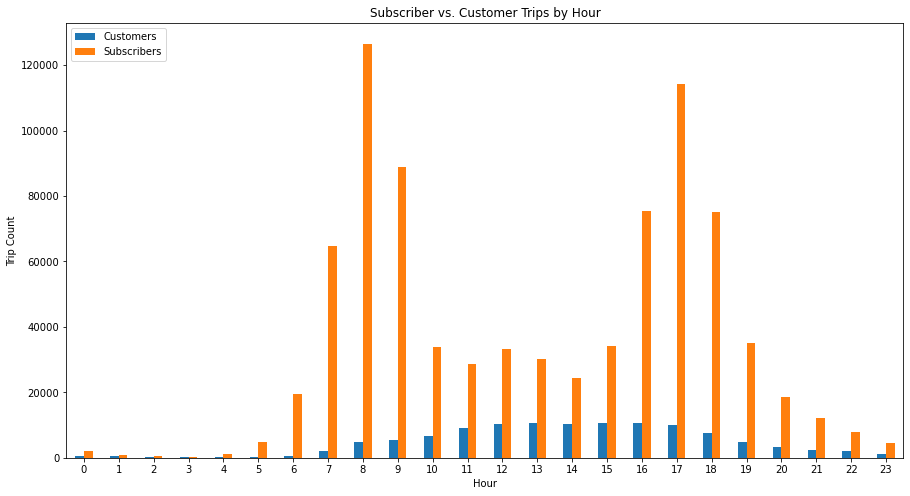

In [349]:
ax = cust_sub_trips_by_hour.plot.bar(rot=0,figsize=(15,8))
ax.set_xlabel('Hour')
ax.set_ylabel('Trip Count')
ax.set_title('Subscriber vs. Customer Trips by Hour')
ax.legend(labels=['Customers', 'Subscribers'],loc='upper left')

### Definition #4: Weekday

Conforming the data closer to what we would expect the typical workweek to look like, these same commuters would be less likely to exhibit the same behavior over the weekend. When we compare the total trip counts by hour by the day of the week (weekend versus weekday), subscribers have the same trip peak hours during the weekday as in the previous definition. However, on a weekend day (Saturday or Sunday), there is a small bump that extends over the late afternoon to early evening timeframe. Filtering the weekend days out of the dataset specifies our intended customer base further.

In [343]:
%%bigquery sub_trips_by_dayofweek_by_hour

SELECT
EXTRACT(HOUR FROM start_date) AS TripStartingHour,
SUM(CASE WHEN EXTRACT(DAYOFWEEK from start_date) IN (1,7) THEN 1 ELSE 0 END) AS NumWeekendTrips,
SUM(CASE WHEN EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) THEN 1 ELSE 0 END) AS NumWeekdayTrips,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_id != end_station_id AND subscriber_type = "Subscriber" # One-way trip and Subscriber filter
GROUP BY TripStartingHour
ORDER BY TripStartingHour

In [344]:
sub_trips_by_dayofweek_by_hour.set_index('TripStartingHour', inplace=True)

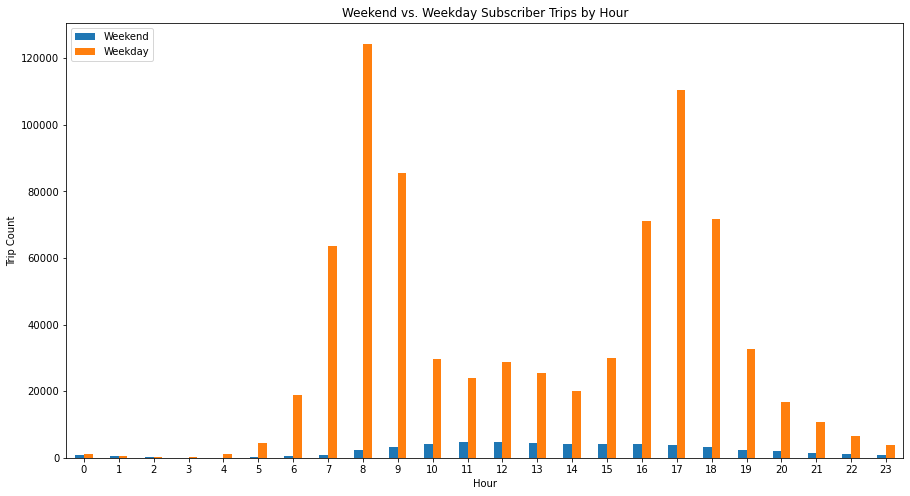

<Figure size 432x288 with 0 Axes>

In [348]:
ax = sub_trips_by_dayofweek_by_hour.plot.bar(rot=0,figsize=(15,8))
plt.figure()
ax.set_xlabel('Hour')
ax.set_ylabel('Trip Count')
ax.set_title('Weekend vs. Weekday Subscriber Trips by Hour')
ax.legend(labels=['Weekend', 'Weekday'],loc='upper left')

### Definition #5: 45 minutes or less

Based on our pricing structure for subscribers, renting a bike out for longer than 45 minutes at a time results in an extra $\$$3 charge per additional 15 minutes. $\$$3 is approximately one fifth of the monthly charge for this type of membership, and if someone took this same trip every Monday-Friday 9-5 commute, the price of a subscription membership would not be worth the deal. We can set that as a boundary because there is a strong pricing incentive to stay under this limit. 

We can confirm this is the case by looking at the average trip duration for either type of membership. For subscribers, where the majority of a single trip lies in the morning or afternoon commute time, the average trip length is 9.05 minutes with a standard deviation of 10.67 minutes. For customers, the average trip length is 31.34 minutes with a standard deviation of 108.04 minutes.

In [359]:
%%bigquery 

SELECT 
ROUND(AVG(duration_sec/60),2) AS AvgTripLength_Min,
ROUND(STDDEV(duration_sec/60),2) AS StdTripLength_Min,
subscriber_type as SubscriberType
FROM (SELECT *,
CASE WHEN (((EXTRACT(HOUR FROM TIMESTAMP_ADD(start_date, INTERVAL CAST(duration_sec/2 AS INT64) SECOND)) < 10) AND 
(EXTRACT(HOUR FROM TIMESTAMP_ADD(start_date, INTERVAL CAST(duration_sec/2 AS INT64) SECOND)) >= 7)) OR 
((EXTRACT(HOUR FROM TIMESTAMP_ADD(start_date, INTERVAL CAST(duration_sec/2 AS INT64) SECOND)) < 19) AND 
(EXTRACT(HOUR FROM TIMESTAMP_ADD(start_date, INTERVAL CAST(duration_sec/2 AS INT64) SECOND)) >= 16))) 
THEN "Commuter Hours" ELSE "Non-Commuter Hours" END AS Commute,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE start_station_id != end_station_id AND Commute = "Commuter Hours" AND EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) # One-way trips, only during commute hours, and on a weekday
GROUP BY SubscriberType

,AvgTripLength_Min,StdTripLength_Min,SubscriberType
0,9.05,10.67,Subscriber
1,31.34,108.04,Customer


### Feature engineering the one-way trips dataset

The saved view that is referenced in the following section contains additional features, such as trip length and other timestamp variables, to assist with discovering patterns within the one-way trips dataset.

### Saved view: `massive-plasma-276423.test.one_way_trips_tagged_commuters_with_geo`

```sql
SELECT
  trip_id,
  subscriber_type,
  CASE
    WHEN (EXTRACT(HOUR FROM TIMESTAMP_ADD(start_date, INTERVAL CAST(duration_sec/2 AS INT64) SECOND)) < 10) AND (EXTRACT(HOUR FROM TIMESTAMP_ADD(start_date, INTERVAL CAST(duration_sec/2 AS INT64) SECOND)) >= 7) AND (duration_sec/60 <= 45) THEN 1
    ELSE 0 END AS is_morning_commute,
  CASE WHEN(EXTRACT(HOUR FROM TIMESTAMP_ADD(start_date, INTERVAL CAST(duration_sec/2 AS INT64) SECOND)) < 19) AND (EXTRACT(HOUR FROM TIMESTAMP_ADD(start_date, INTERVAL CAST(duration_sec/2 AS INT64) SECOND)) >= 16) AND (duration_sec/60 <= 45) THEN 1
    ELSE 0 END AS is_afternoon_commute,
  bike_number,
  start_date,
  EXTRACT(YEAR FROM start_date) AS start_year,
  EXTRACT(MONTH FROM start_date) AS start_month,
  EXTRACT(DAY FROM start_date) AS start_day,
  EXTRACT(HOUR FROM start_date) AS start_hour,
  EXTRACT(DAYOFWEEK FROM start_date) AS start_dayofweek,
  start_station_name,
  start_station_id,
  end_date,
  EXTRACT(YEAR FROM end_date) AS end_year,
  EXTRACT(MONTH FROM end_date) AS end_month,
  EXTRACT(DAY FROM end_date) AS end_day,
  EXTRACT(HOUR FROM end_date) AS end_hour,
  EXTRACT(DAYOFWEEK FROM end_date) AS end_dayofweek,
  end_station_name,
  end_station_id,
  duration_sec,
  ROUND((ST_DISTANCE(start_WKT,end_WKT)/1000)*0.621371,4) AS trip_dist_mi,
  start_longitude,
  start_latitude,
  start_WKT,
  end_longitude,
  end_latitude,
  end_WKT,
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips` AS t
JOIN (
  SELECT
    station_id AS station_id1,
    ST_GeogPoint(longitude,
      latitude) AS start_WKT,
    longitude AS start_longitude,
    latitude AS start_latitude,
  FROM
    `bigquery-public-data.san_francisco.bikeshare_stations`) AS t1
ON
  t1.station_id1 = t.start_station_id
JOIN (
  SELECT
    station_id AS station_id2,
    ST_GeogPoint(longitude,
      latitude) AS end_WKT,
    longitude AS end_longitude,
    latitude AS end_latitude,
  FROM
    `bigquery-public-data.san_francisco.bikeshare_stations`) AS t2
ON
  t2.station_id2 = t.end_station_id
WHERE
  start_station_id != end_station_id # One-way trips
```

### Top 5 Commuter Trips

Based on what we've discovered, we can aggregate the data to find our "commuter" rides: one-way, with a subscriber membership, taken during either morning or afternoon commutes, on a weekday, and lasting 45 minutes or less.

In the table output and geographic plot below, you can see that top trips are either transfers between transit types, or trips that start or end at a transit station. Three out of the five have a station by the Embarcadero BART station, and two including a Caltrain station. Embarcadero at Folsom is a MUNI stop. The top two trips contain the same stations in reverse order, which means there likely is a hub of housing or companies around the 2nd at Townsend station. Overall, the top 5 trips do not have a majority of the total commuter trips by any means (less than 1% of the total each).

In [356]:
%%bigquery commuter_geo

SELECT
start_station_id, end_station_id, start_station_name, end_station_name, trip_dist_mi, start_longitude, start_latitude, end_longitude, end_latitude,
COUNT(*) AS trip_count,
ROUND(COUNT(*) / SUM(COUNT(*)) OVER (),4)*100 AS percent_of_total,
FROM `massive-plasma-276423.test.one_way_trips_tagged_commuters_with_geo` # One-way trips saved view
WHERE (is_morning_commute = 1 OR is_afternoon_commute = 1) AND subscriber_type = "Subscriber" AND duration_sec/60 <=45 AND start_dayofweek IN (2,3,4,5,6) # Commuter filters
GROUP BY start_station_id, end_station_id, start_station_name, end_station_name, trip_dist_mi, start_longitude, start_latitude, end_longitude, end_latitude
ORDER BY trip_count DESC
LIMIT 5

In [357]:
commuter_geo[['start_station_name', 'end_station_name', 'trip_count', 'percent_of_total']]

,start_station_name,end_station_name,trip_count,percent_of_total
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5020,0.96
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4962,0.95
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4913,0.94
3,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4779,0.91
4,Embarcadero at Sansome,Steuart at Market,4686,0.89


Text(0, 0.5, 'Latitude')

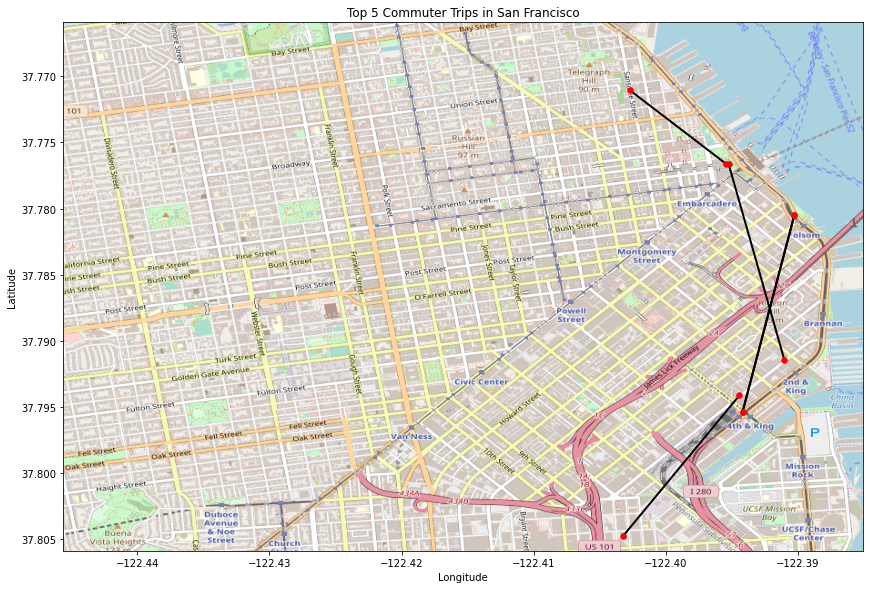

In [358]:
BBox = (-122.4456,-122.3851,37.8059,37.7659)
mymap = plt.imread('map.png')
fig, ax = plt.subplots(figsize = (1.2*11.94,12))
ax.imshow(mymap, zorder=0, extent = BBox, aspect= 'equal')
for i in range(commuter_geo.start_longitude.shape[0]):
    if i < 5:
        plt.plot([commuter_geo.start_longitude[i],commuter_geo.end_longitude[i]], [commuter_geo.start_latitude[i],commuter_geo.end_latitude[i]], c='black', zorder=2, lw=2)
    else:
        plt.plot([commuter_geo.start_longitude[i],commuter_geo.end_longitude[i]], [commuter_geo.start_latitude[i],commuter_geo.end_latitude[i]], c='b', zorder=1, lw=2)
ax.scatter(commuter_geo.start_longitude, commuter_geo.start_latitude, zorder=3, alpha=1, c='r', s=30)
ax.scatter(commuter_geo.end_longitude, commuter_geo.end_latitude, zorder=3, alpha=1, c='r', s=30)
ax.set_title('Top 5 Commuter Trips in San Francisco')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## **Offer recommendation**

### One-way customer trips to help restock stations for commuters

To help rearrange the bikes during peak usage (7-10AM and 4-7PM), we can encourage customers to do the labor in exchange for reduced future fares with a credit system. I calculated the total number of customer one-way trips that end during either commute or inbetween the morning and afternoon commutes (10AM-4PM). Over 80% of customer one-way trips occur during these times. 

Although this could be modified depending on how costs have changed since 2016, I expect that you could give something like $1 for every extra tenth of their average trip's distance to move the bike to a peak commuter station instead of their typical station route. I included example credit calculations in the following tables. `credit_1st_quarter_mi` and `credit_2nd_quarter_mi` are credits (in dollars) that could be applied to future rides.

Features:
- Due to the longer time period between the morning and afternoon commutes, the credit for the "Between" zone will be half the cost. 
- The credit earned/tenth of a mile calculation for all zones will be halved every additional quarter mile.
- The credit is unavailable for trips outside of these commuter time windows.
- The credit is unavailable for customers whose typical trip history does not include these peak travel times.

More  requires being able to aggregate and summarize individual ride history as well as cost to restock bikes around different stations without using riders (which sets the maximum price point for the credit system), but this information was not available in these datasets. This offer could be applied at scale by comparing station peaks with individual ride history. Each customer could have their own set of restocking hours where they could earn credits for future rides.

In [334]:
%%bigquery

SELECT
which_commute,
ROUND(AVG(duration_sec/60),2) AS duration_min_avg,
ROUND(AVG(trip_dist_mi),2) AS trip_dist_mi_avg,
ROUND(AVG(trip_dist_mi)/10,3) AS one_tenth_mi,
CASE WHEN which_commute = "Between" THEN ROUND(0.125/(AVG(trip_dist_mi)/10),2) ELSE (CASE WHEN which_commute = "Other" THEN 0 ELSE ROUND(0.25/(AVG(trip_dist_mi)/10),2) END) END AS credit_1st_quarter_mi,
CASE WHEN which_commute = "Between" THEN ROUND(0.0625/(AVG(trip_dist_mi)/10),2) ELSE (CASE WHEN which_commute = "Other" THEN 0 ELSE ROUND(0.125/(AVG(trip_dist_mi)/10),2) END) END AS credit_2nd_quarter_mi,
COUNT(*) AS trip_count,
ROUND((COUNT(*) / SUM(COUNT(*)) OVER ())*100,2) AS percent_of_total,

FROM (SELECT *, CASE WHEN EXTRACT(HOUR from end_date) >= 7 AND EXTRACT(HOUR from end_date) < 10 THEN "Morning" ELSE (CASE WHEN EXTRACT(HOUR from end_date) >= 16 AND EXTRACT(HOUR from end_date) < 19 THEN "Afternoon" ELSE (CASE WHEN EXTRACT(HOUR from end_date) >= 10 AND EXTRACT(HOUR from end_date) < 16 THEN "Between" ELSE "Other" END) END) END AS which_commute FROM `massive-plasma-276423.test.one_way_trips_tagged_commuters_with_geo`) # One-way trips saved view
WHERE subscriber_type = "Customer" AND start_dayofweek IN (2,3,4,5,6) # Commuter filters
GROUP BY which_commute
ORDER BY trip_count DESC

,which_commute,duration_min_avg,trip_dist_mi_avg,one_tenth_mi,credit_1st_quarter_mi,credit_2nd_quarter_mi,trip_count,percent_of_total
0,Between,38.89,0.90,0.090,1.39,0.69,29071,41.60
1,Afternoon,44.21,0.96,0.096,2.61,1.31,19990,28.60
2,Other,49.33,0.94,0.094,0.00,0.00,12628,18.07
3,Morning,33.11,0.98,0.098,2.54,1.27,8199,11.73


### Conclusion and other recommendations

Since the average one-way trip for customers is around 31 minutes, which is greater than the maximum trip time before accruing an additional $\$$3 fee (30 minutes), it might also be advantageous to look into having a Single, Leisure Ride option that costs $1 more, capped at 60 minutes, with a $\$$6 fee for every 15 minutes over 60 minutes. A customer who feels rushed to make a 30 minute limit may opt in for a slightly more expensive offer for the convenience.

Lastly, for encouraging more ridership on the weekends for subscribers, whose aggregated number of trips drops dramatically on Saturdays and Sundays, adding a perk such as guest weekend privileges, would encourage more trips in general as well as longer trips since commuters could start to leverage their membership for both work and for their social network. It has an added bonus that any guest of a subscriber (anyone over 18 years of age) can be logged in our database, and we can send promotions to encourage conversion into a customer.

If there was more time, I would have liked to assessed outliers from the `trips` dataset by calculating the average trip times for rounded trip distances in the one-way dataset. I did not include that in this report because commuter trips were already capped at 45 minutes or less. Overall, there were some limitations in generalizing customer behavior, since we could not track individual members across time. However, it was suffient for identifying what an aggregate commuter ridership looks like, recommend a restocking schemes, and highlight some other membership opportunities.
